# Astrophysical Techniques
### Assignment 3

Shoaib Shamsi

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.style.use('seaborn-v0_8-colorblind')

### Task 1

In [2]:
# Default parameters
D = 8  # Mirror diameter in meters
q = 0.7  # Quantum efficiency
V = 25  # Magnitude of the object
f_number = 2.77  # f/#
S_dc = 3  # Dark current in e-/s/pix
B_sky = 22  # Sky brightness in mag/arcsec^2
S_ro2 = 5  # Read-out noise in e-/pix
r = 2  # PSF radius in arcseconds
u = 27  # Pixel size in micrometers
SNR_target = 10  # Target signal-to-noise ratio
f0 = 1000  # Flux for a zero-magnitude source in e-/s/cm^2/Å
bandwidth = 900  # V-filter bandwidth in Å
X = 1  # Zenith factor

### Let's make some helper functions.

First, we know that
$$m - M_r = -2.5 \log_{10}{\left(\frac{f}{f_r}\right)}$$

For a reference flux $f_r = f_0$, the reference magnitude $M_r = 0$ so,

$$m = -2.5 \log_{10}{\left(\frac{f}{f_0}\right)}$$

And hence:

$$f = f_0 \times 10^{-0.4 m}$$

In [3]:
def magnitude2flux(magnitude, reference_flux=f0):
    """Calculate the flux in in e-/s/cm^2/Å for a given magnitude."""
    return reference_flux * 10**(-0.4 * magnitude)

Now we will consider the number of electrons per second per unit wavelength generated by a point source of flux $f$ (number of electrons per second per $\text{cm}^2$ per unit wavelength) for a telescope with diameter $D$ m:

$$f \times \pi \left( \frac{D \times 10^2}{2} \right)^2$$

Now we consider the number of pixels covered by a point source which has a circular aperture of radius $r$ arcsec. Firstly, the pixel scale ($\text{arcsec}^2$ covered by one pixel) of a setup with focal length $l_{foc}$ m and square pixel length $u ~ \mu\text{m}$ is:

$$\left( \frac{206265 \times u \times 10^{-6}}{l_{foc}} \right)^2$$

Thus the number of covered pixels are:

$$\pi \left( \frac{r ~ l_{foc} ~ 10^6}{206265 ~ u} \right)^2$$

Finally, the number of electrons per second per unit wavelength generated in one pixel is:

$$f \times q \times \pi \left( \frac{D \times 10^2}{2} \right)^2 \times \frac{(206265 ~ u)^2}{\pi (r ~ l_{foc} ~ 10^6)^2} = \frac{f ~ 206265^2 ~ u^2 ~ 10^{-8}}{4 ~ r^2 ~ f/\#^2}$$

In [4]:
def num_pixels_covered(psf_radius=r,
                       focal_length=D*f_number,
                       pixel_size=u):
    return np.pi * ((psf_radius * focal_length * 1E6) / (206265 * pixel_size))**2

def magnitude2electrons(magnitude,
                        reference_flux=f0,
                        aperture=D,
                        quantum_efficiency=q,
                        bandwidth=bandwidth):
    """Calculate electrons per second per unit wavelength. """
    flux = magnitude2flux(magnitude=magnitude, reference_flux=reference_flux)
    return bandwidth * quantum_efficiency * flux * np.pi * (50 * aperture)**2

def magnitude2electrons_per_pixel(magnitude,
                                  reference_flux=f0,
                                  pixel_size=u,
                                  psf_radius=r,
                                  focal_ratio=f_number,
                                  quantum_efficiency=q,
                                  bandwidth=bandwidth):
    """Calculate electrons per second per unit wavelength per pixel."""
    flux = magnitude2flux(magnitude=magnitude, reference_flux=reference_flux)
    return (bandwidth * quantum_efficiency * flux * 206265**2 * pixel_size**2 * 1E-8) / (4 * psf_radius**2 * focal_ratio**2)

We can manipulate the equation:

$$SNR = \frac{S_{sig} t}{\sqrt{S_{sig} t + R_{sky} t + S_{dc} t n + S^2_{ro} n}}$$

And find the solution to $t$ as the positive root for the resulting quadratic equation:

$$t = SNR \times \frac{SNR (S_{sig} + R_{sky} + S_{dc} n) + \sqrt{SNR^2 (S_{sig} + R_{sky} + S_{dc} n)^2 + 4 S_{sig}^2 S^2_{ro} n}}{2 S_{sig}^2}$$

In [5]:
def exposure_time(source_mag=V,
                  reference_flux=f0,
                  aperture=D,
                  bandwidth=bandwidth,
                  quantum_efficiency=q,
                  sky_mag=B_sky,
                  pixel_size=u,
                  psf_radius=r,
                  focal_ratio=f_number,
                  S_dc=S_dc,
                  S_ro2=S_ro2,
                  SNR=SNR_target):
    S_sig = magnitude2electrons(magnitude=source_mag,
                                reference_flux=reference_flux,
                                aperture=aperture,
                                quantum_efficiency=quantum_efficiency,
                                bandwidth=bandwidth)
    S_sky = magnitude2electrons_per_pixel(magnitude=sky_mag,
                                          reference_flux=reference_flux,
                                          pixel_size=pixel_size,
                                          psf_radius=psf_radius,
                                          focal_ratio=focal_ratio,
                                          quantum_efficiency=quantum_efficiency,
                                          bandwidth=bandwidth)
    num_pixels = num_pixels_covered(psf_radius=psf_radius,
                                    focal_length=aperture*focal_ratio,
                                    pixel_size=pixel_size)
    R_sky = S_sky * num_pixels
    
    time_dep_noise = S_sig + R_sky + S_ro2 * num_pixels
    return SNR * ((SNR * time_dep_noise + np.sqrt(SNR**2 * time_dep_noise**2 + 4 * S_sig**2 * S_ro2 * num_pixels)) / (2 * S_sig**2))

def exposure_time(source_mag=V,
                  reference_flux=f0,
                  aperture=D,
                  bandwidth=bandwidth,
                  quantum_efficiency=q,
                  sky_mag=B_sky,
                  pixel_size=u,
                  psf_radius=r,
                  focal_ratio=f_number,
                  S_dc=S_dc,
                  S_ro2=S_ro2,
                  SNR=SNR_target):
    S_sig = magnitude2electrons_per_pixel(magnitude=source_mag,
                                          reference_flux=reference_flux,
                                          pixel_size=pixel_size,
                                          psf_radius=psf_radius,
                                          focal_ratio=focal_ratio,
                                          quantum_efficiency=quantum_efficiency,
                                          bandwidth=bandwidth)
    S_sky = magnitude2electrons_per_pixel(magnitude=sky_mag,
                                          reference_flux=reference_flux,
                                          pixel_size=pixel_size,
                                          psf_radius=psf_radius,
                                          focal_ratio=focal_ratio,
                                          quantum_efficiency=quantum_efficiency,
                                          bandwidth=bandwidth)
    num_pixels = num_pixels_covered(psf_radius=psf_radius,
                                    focal_length=aperture*focal_ratio,
                                    pixel_size=pixel_size)
    S_sig = S_sig * num_pixels
    R_sky = S_sky * num_pixels
    S_dc = S_dc * num_pixels
    
    time_dep_noise = S_sig + R_sky + S_dc
    return SNR * ((SNR * time_dep_noise + np.sqrt(SNR**2 * time_dep_noise**2 + 4 * S_sig**2 * S_ro2 * num_pixels)) / (2 * S_sig**2))

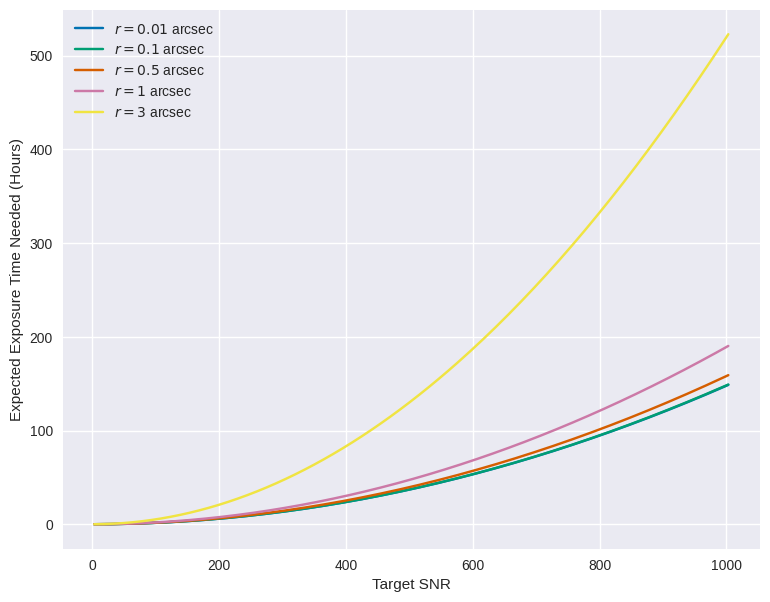

In [6]:
times = []

SNRs = np.linspace(3, 1003, 200)
r_array = [0.01, 0.1, 0.5, 1, 3]

for r in r_array:
    time_array = exposure_time(psf_radius=r, SNR=SNRs)
    times.append(time_array)

plt.figure(figsize=(9,7))

for r, time_array in zip(r_array, times):
    plt.plot(SNRs, time_array/3600, label=f'$r = {r}$ arcsec')

plt.xlabel('Target SNR')
plt.ylabel('Expected Exposure Time Needed (Hours)')

plt.legend()
plt.show()

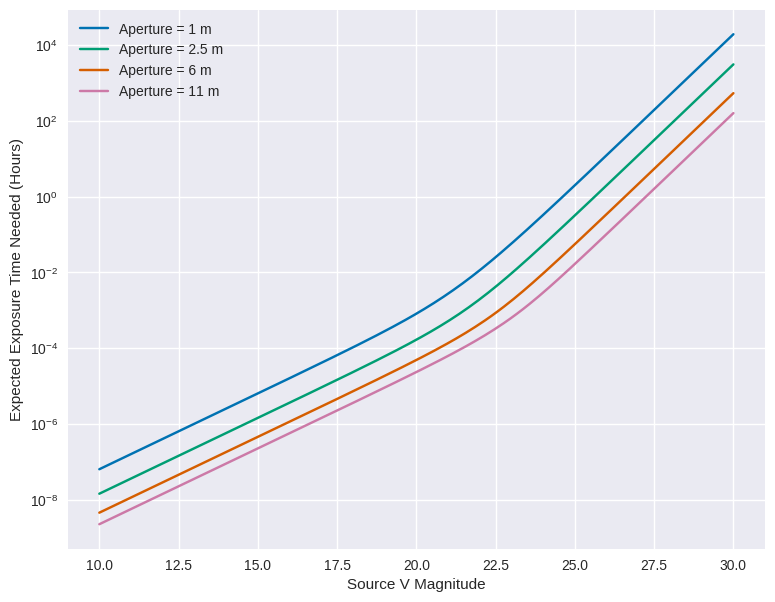

In [7]:
times = []

Vs = np.linspace(10, 30, 200)
D_array = [1, 2.5, 6, 11]

for D in D_array:
    time_array = exposure_time(source_mag=Vs, aperture=D)
    times.append(time_array)

plt.figure(figsize=(9,7))

for D, time_array in zip(D_array, times):
    plt.plot(Vs, time_array/3600, label=f'Aperture = {D} m')

plt.xlabel('Source V Magnitude')
plt.ylabel('Expected Exposure Time Needed (Hours)')

plt.yscale('log')

plt.legend()
plt.show()

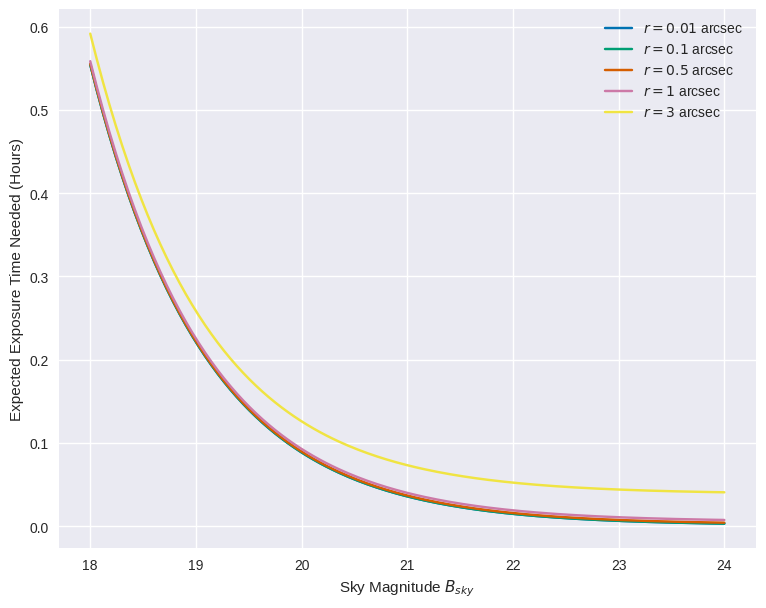

In [8]:
times = []

B_skys = np.linspace(18, 24, 200)
r_array = [0.01, 0.1, 0.5, 1, 3]

for r in r_array:
    time_array = exposure_time(sky_mag=B_skys, psf_radius=r)
    times.append(time_array)

plt.figure(figsize=(9,7))

for r, time_array in zip(r_array, times):
    plt.plot(B_skys, time_array/3600, label=f'$r = {r}$ arcsec')

plt.xlabel('Sky Magnitude $B_{sky}$')
plt.ylabel('Expected Exposure Time Needed (Hours)')

# plt.yscale('log')

plt.legend()
plt.show()

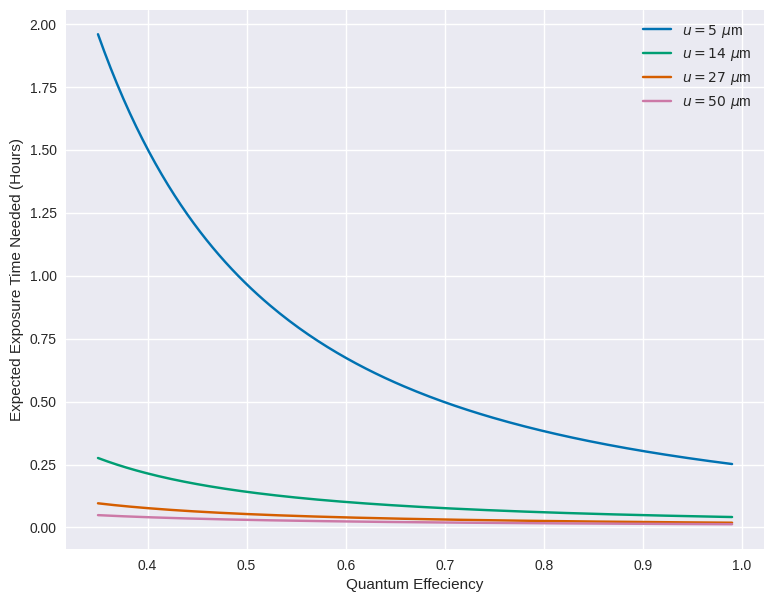

In [9]:
times = []

qs = np.linspace(0.35, 0.99, 200)
u_array = [5, 14, 27, 50]

for u in u_array:
    time_array = np.array([exposure_time(quantum_efficiency=q, pixel_size=u) for q in qs])
    times.append(time_array)

plt.figure(figsize=(9,7))

for u, time_array in zip(u_array, times):
    plt.plot(qs, time_array/3600, label=f'$u = {u}~\mu$m')

plt.xlabel('Quantum Effeciency')
plt.ylabel('Expected Exposure Time Needed (Hours)')

# plt.yscale('log')

plt.legend()
plt.show()

In [10]:
def exposure_time_extended(source_mag=V,
                           reference_flux=f0,
                           aperture=D,
                           bandwidth=bandwidth,
                           quantum_efficiency=q,
                           sky_mag=B_sky,
                           pixel_size=u,
                           psf_radius=r,
                           focal_ratio=f_number,
                           S_dc=S_dc,
                           S_ro2=S_ro2,
                           SNR=SNR_target,
                           num_pixels=4):
    
    S_sig = magnitude2electrons_per_pixel(magnitude=source_mag,
                                          reference_flux=reference_flux,
                                          pixel_size=pixel_size,
                                          psf_radius=psf_radius,
                                          focal_ratio=focal_ratio,
                                          quantum_efficiency=quantum_efficiency,
                                          bandwidth=bandwidth)
    
    S_sig = S_sig * num_pixels
    
    S_sky = magnitude2electrons_per_pixel(magnitude=sky_mag,
                                          reference_flux=reference_flux,
                                          pixel_size=pixel_size,
                                          psf_radius=psf_radius,
                                          focal_ratio=focal_ratio,
                                          quantum_efficiency=quantum_efficiency,
                                          bandwidth=bandwidth)
    R_sky = S_sky * num_pixels
    S_dc = S_dc * num_pixels
    
    time_dep_noise = S_sig + R_sky + S_dc
    return SNR * ((SNR * time_dep_noise + np.sqrt(SNR**2 * time_dep_noise**2 + 4 * S_sig**2 * S_ro2 * num_pixels)) / (2 * S_sig**2))

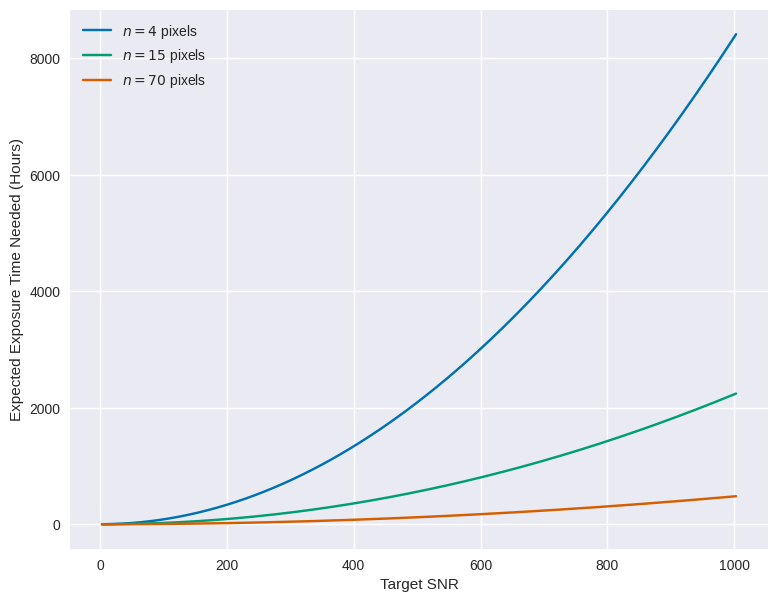

In [11]:
times = []

SNRs = np.linspace(3, 1003, 200)
n_array = [4, 15, 70]

for n in n_array:
    time_array = exposure_time_extended(SNR=SNRs, num_pixels=n)
    times.append(time_array)

plt.figure(figsize=(9,7))

for n, time_array in zip(n_array, times):
    plt.plot(SNRs, time_array/3600, label=f'$n = {n}$ pixels')

plt.xlabel('Target SNR')
plt.ylabel('Expected Exposure Time Needed (Hours)')

plt.legend()
plt.show()

### Task 2

The Milanković telescope has an aperture of $1.4~$m. The focal length is $11.2~$m and the focal ratio is $f/8$.

The SBIG STXL-6303E CCD has a pixel size of $9~\mu$m. The peak quantum efficiency is $0.68$. The readout noise is $11~e^-/pix$, and darc current is $0.3~e^-/s/pix$. 

Andromeda has an apparent visual magnitude of $3.4$. We'll say that the apparent size in arcseconds is $10680 \times 3780$. How many pixels on the CCD would this cover?

In [12]:
milankovic_pixel_scale = ((206265 * 9 * 1E-6) / 11.2)**2
andromeda_sky_area = 10680*3780 # arcsec^2
andromeda_num_pixels = andromeda_sky_area / milankovic_pixel_scale

print(f'Andromeda would cover around {int(andromeda_num_pixels):,} pixels on the CCD in total if the CCD was big enough.')

Andromeda would cover around 1,469,477,689 pixels on the CCD in total if the CCD was big enough.


In this case, Andromeda would not fill the CCD's FOV, so we will assume the CCD uses all $3072 \times 2048$ of its pixels.

In [13]:
# New parameters
D = 1.4  # Mirror diameter in meters
q = 0.68  # Quantum efficiency
V = 3.4  # Magnitude of the object
f_number = 8  # f/#
S_dc = 0.3  # Dark current in e-/s/pix
B_sky = 19  # Sky brightness in mag/arcsec^2
S_ro2 = 11  # Read-out noise in e-/pix
r = 2  # PSF radius in arcseconds
u = 9  # Pixel size in micrometers
SNR_target = 100  # Target signal-to-noise ratio
f0 = 1000  # Flux for a zero-mag7689nitude source in e-/s/cm^2/Å
bandwidth = 900  # V-filter bandwidth in Å
X = 1  # Zenith factor

In [14]:
exposure_time_extended(source_mag=V,
                       reference_flux=f0,
                       aperture=D,
                       bandwidth=bandwidth,
                       quantum_efficiency=q,
                       sky_mag=B_sky,
                       pixel_size=u,
                       psf_radius=r,
                       focal_ratio=f_number,
                       S_dc=S_dc,
                       S_ro2=S_ro2,
                       SNR=SNR_target,
                       num_pixels=3072*2048)

1.4795969673392683e-07

This calculations suggests that we need an exposure of $1.48 \times 10^{-7}$ s to get $SNR = 100$, which is a bit too low.